
## 1.Data Exploration and Preprocessing


In [1]:

!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d aithammadiabdellatif/binarysegmentation-endovis-17

100% 1.32G/1.32G [00:41<00:00, 34.4MB/s]
100% 1.32G/1.32G [00:42<00:00, 33.8MB/s]


In [7]:
!unzip binarysegmentation-endovis-17.zip

Archive:  binarysegmentation-endovis-17.zip
  inflating: BinarySegmentation/binary_masks/1frame225.png  
  inflating: BinarySegmentation/binary_masks/1frame226.png  
  inflating: BinarySegmentation/binary_masks/1frame227.png  
  inflating: BinarySegmentation/binary_masks/1frame228.png  
  inflating: TypeSegmentation/masks/4frame299.png  


In [8]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, VerticalFlip, Rotate

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split=0.2):
    """ Load the images and masks """
    images = sorted(glob(f"{path}/images/*"))
    masks = sorted(glob(f"{path}/binary_masks/*"))
    """ Split the data """
    split_size = int(len(images) * split)
    train_x, test_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=split_size, random_state=42)

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    """ Performing data augmentation. """
    H = 512
    W = 512

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the dir name and image name """
        name = x.split("/")[-1]


        """ Read the image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            aug = Rotate(limit=45,p =1.0,crop_border =True )
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            #print(len(X))
            Y =[y]

        idx = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))
            m = m/255.0
            m = (m > 0.5) * 255

            if len(X) == 1:  # each loop will take one image
                tmp_image_name = name
                tmp_mask_name  = name
            else:
                tmp_image_name = f"{name.split('.')[0]}_{idx}.{name.split('.')[1]}"
                tmp_mask_name  = f"{name.split('.')[0]}_{idx}.{name.split('.')[1]}"
                #print(tmp_image_name)

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)
            #print(image_path)
            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1



if __name__ == "__main__":
    """ Load the dataset """
    dataset_path = "/content/BinarySegmentation"
    (train_x, train_y), (test_x, test_y) = load_data(dataset_path,split=0.2)

    print("Train: ", len(train_x))
    print("Test: ", len(test_x))

    create_dir("new_data/train/image/")
    create_dir("new_data/train/mask/")
    create_dir("new_data/test/image/")
    create_dir("new_data/test/mask/")

    augment_data(train_x, train_y, "new_data/train/", augment=True)
    augment_data(test_x, test_y, "new_data/test/", augment=False)

Train:  420
Test:  105


100%|██████████| 105/105 [00:06<00:00, 16.48it/s]


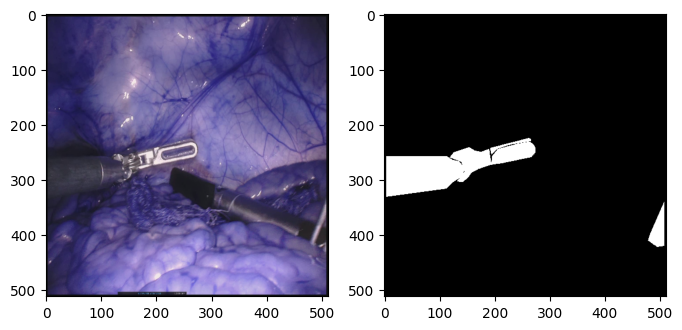

In [9]:
from matplotlib import pyplot as plt
#Original image and it's mask
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(cv2.imread('/content/new_data/train/image/1frame228_0.png'))
plt.subplot(122)
plt.imshow(cv2.imread('/content/new_data/train/mask/1frame228_0.png'))



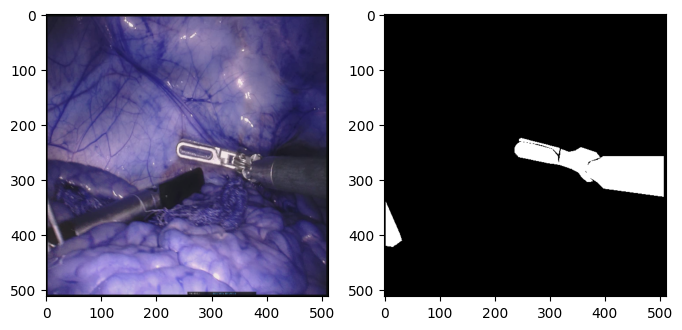

In [10]:
#Same image as before after using HorizontalFlip
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(cv2.imread('/content/new_data/train/image/1frame228_1.png'))
plt.subplot(122)
plt.imshow(cv2.imread('/content/new_data/train/mask/1frame228_1.png'))

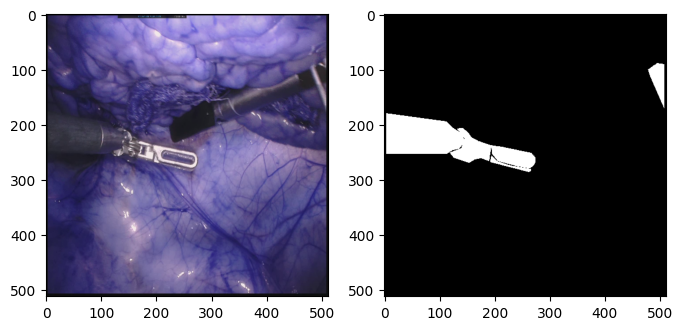

In [11]:
#Same image as before after using VerticalFlip
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(cv2.imread('/content/new_data/train/image/1frame228_2.png'))
plt.subplot(122)
plt.imshow(cv2.imread('/content/new_data/train/mask/1frame228_2.png'))

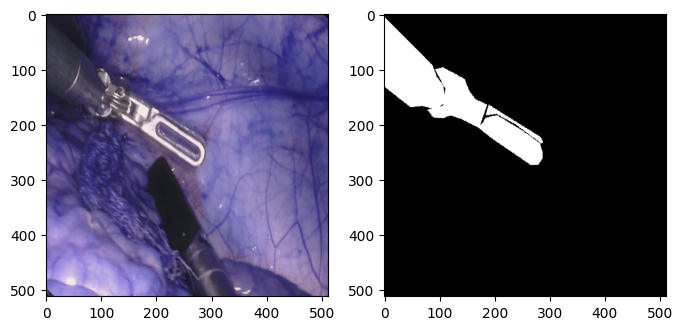

In [12]:
#Same image as before after using Rotation
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(cv2.imread('/content/new_data/train/image/1frame228_3.png'))
plt.subplot(122)
plt.imshow(cv2.imread('/content/new_data/train/mask/1frame228_3.png'))

___
## 2.U-Net Architecture


###2.1 Building U-Net Model


In [13]:
#To Do
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

### 2.2 Compile the model with an appropriate loss function and optimizer.

In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

H = 512
W = 512

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path):
    x = sorted(glob(os.path.join(path, "image", "*")))
    y = sorted(glob(os.path.join(path, "mask", "*")))
    return x, y

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)



if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 6
    lr = 1e-4
    num_epochs = 8
    model_path = os.path.join("files", "model.h5")
    csv_path = os.path.join("files", "data.csv")

    """ Dataset """
    dataset_path = os.path.join("new_data")
    train_path = os.path.join(dataset_path, "train")
    test_path = os.path.join(dataset_path, "test")

    train_x, train_y = load_data(train_path)
    train_x, train_y = shuffling(train_x, train_y)
    test_x, test_y = load_data(test_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)

    """ Model """
    model = build_unet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)



Train: 1680 - 1680
test: 105 - 105


---
## 3.Model Training

---

In [17]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=False),
    ]

model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        shuffle=False
    )

Epoch 1/8
280/280 [==============================] - ETA: 0s - loss: 0.2072 - dice_coef: 0.7928 - iou: 0.6672 - recall: 0.9308 - precision: 0.8205
Epoch 1: val_loss improved from inf to 0.93961, saving model to files/model.h5
280/280 [==============================] - 477s 1s/step - loss: 0.2072 - dice_coef: 0.7928 - iou: 0.6672 - recall: 0.9308 - precision: 0.8205 - val_loss: 0.9396 - val_dice_coef: 0.0604 - val_iou: 0.0312 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/8
280/280 [==============================] - ETA: 0s - loss: 0.1270 - dice_coef: 0.8730 - iou: 0.7778 - recall: 0.9460 - precision: 0.8824
Epoch 2: val_loss improved from 0.93961 to 0.20831, saving model to files/model.h5
280/280 [==============================] - 418s 1s/step - loss: 0.1270 - dice_coef: 0.8730 - iou: 0.7778 - recall: 0.9460 - precision: 0.8824 - val_loss: 0.2083 - val_dice_coef: 0.7921 - val_iou: 0.6758 - val_recall: 0.8853 - val_precision: 0.8116 - lr: 1.0000e-04
Epoch 

---
## 4.Model Evaluation

---

In [18]:
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import pandas as pd

H = 512
W = 512

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def save_results(image, mask, y_pred, save_image_path):

    line = np.ones((H, 10, 3)) * 128

    """ Mask """
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)

    """ Predicted Mask """
    y_pred = np.expand_dims(y_pred, axis=-1)    ## (512, 512, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)  ## (512, 512, 3)
    y_pred = y_pred * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Loading model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
        model = tf.keras.models.load_model("files/model.h5")

    """ Load the dataset """
    test_x = sorted(glob(os.path.join("new_data", "test", "image", "*")))
    test_y = sorted(glob(os.path.join("new_data", "test", "mask", "*")))
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Evaluation and Prediction """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y = mask/255.0
        y = y > 0.5
        y = y.astype(np.int32)

        """ Prediction """
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the prediction """
        save_image_path = f"results/{name}"
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating the metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")

Test: 105 - 105


  0%|          | 0/105 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  1%|          | 1/105 [00:05<10:13,  5.90s/it]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 2/105 [00:06<04:42,  2.74s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 3/105 [00:06<02:53,  1.70s/it]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 4/105 [00:07<02:02,  1.22s/it]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 5/105 [00:07<01:34,  1.06it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 6/105 [00:08<01:17,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 7/105 [00:09<01:16,  1.28it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 8/105 [00:09<01:18,  1.24it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 9/105 [00:10<01:17,  1.23it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 10/105 [00:11<01:17,  1.23it/s]

1/1 [==============================] - 0s 53ms/step


 10%|█         | 11/105 [00:12<01:14,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 12/105 [00:12<01:04,  1.45it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 13/105 [00:13<00:58,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 14/105 [00:13<00:52,  1.73it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 15/105 [00:14<00:48,  1.86it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 16/105 [00:14<00:45,  1.94it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 17/105 [00:15<00:43,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 18/105 [00:15<00:41,  2.08it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 19/105 [00:16<00:42,  2.02it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 20/105 [00:16<00:42,  1.98it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 21/105 [00:17<00:41,  2.03it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 22/105 [00:17<00:40,  2.03it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 23/105 [00:18<00:40,  2.02it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 24/105 [00:18<00:38,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 25/105 [00:18<00:37,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 26/105 [00:19<00:36,  2.17it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 27/105 [00:19<00:35,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 28/105 [00:20<00:35,  2.19it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 29/105 [00:20<00:34,  2.21it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 30/105 [00:21<00:34,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 31/105 [00:21<00:35,  2.08it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 32/105 [00:22<00:35,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 33/105 [00:23<00:41,  1.75it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 34/105 [00:23<00:46,  1.53it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 35/105 [00:24<00:49,  1.41it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 36/105 [00:25<00:51,  1.35it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 37/105 [00:26<00:51,  1.33it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 38/105 [00:26<00:44,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 39/105 [00:27<00:40,  1.65it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 40/105 [00:27<00:36,  1.78it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 41/105 [00:28<00:34,  1.88it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 42/105 [00:28<00:32,  1.97it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 43/105 [00:29<00:30,  2.04it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 44/105 [00:29<00:29,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 45/105 [00:29<00:28,  2.10it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 46/105 [00:30<00:27,  2.14it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 47/105 [00:30<00:26,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 48/105 [00:31<00:26,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 49/105 [00:31<00:25,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 50/105 [00:32<00:25,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 51/105 [00:32<00:25,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 52/105 [00:33<00:25,  2.07it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 53/105 [00:33<00:24,  2.13it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 54/105 [00:34<00:23,  2.17it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 55/105 [00:34<00:23,  2.11it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 56/105 [00:35<00:23,  2.05it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 57/105 [00:35<00:22,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 58/105 [00:36<00:22,  2.08it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 59/105 [00:36<00:24,  1.91it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 60/105 [00:37<00:26,  1.67it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 61/105 [00:38<00:28,  1.57it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 62/105 [00:39<00:29,  1.46it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 63/105 [00:39<00:30,  1.37it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 64/105 [00:40<00:28,  1.46it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 65/105 [00:40<00:25,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 66/105 [00:41<00:22,  1.77it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 67/105 [00:41<00:20,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 68/105 [00:42<00:19,  1.93it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 69/105 [00:42<00:17,  2.01it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 70/105 [00:43<00:16,  2.08it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 71/105 [00:43<00:15,  2.13it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 72/105 [00:44<00:15,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 73/105 [00:44<00:14,  2.22it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 74/105 [00:44<00:14,  2.14it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 75/105 [00:45<00:13,  2.19it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 76/105 [00:45<00:13,  2.20it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 77/105 [00:46<00:12,  2.21it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 78/105 [00:46<00:12,  2.23it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 79/105 [00:47<00:11,  2.27it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 80/105 [00:47<00:11,  2.27it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 81/105 [00:48<00:10,  2.27it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 82/105 [00:48<00:10,  2.29it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 83/105 [00:48<00:09,  2.29it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 84/105 [00:49<00:09,  2.32it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 85/105 [00:49<00:08,  2.30it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 86/105 [00:50<00:08,  2.28it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 87/105 [00:51<00:09,  1.82it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 88/105 [00:51<00:10,  1.55it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 89/105 [00:52<00:10,  1.48it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 90/105 [00:53<00:10,  1.41it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 91/105 [00:54<00:10,  1.37it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 92/105 [00:54<00:08,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 93/105 [00:55<00:07,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 94/105 [00:55<00:05,  1.84it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 95/105 [00:56<00:05,  1.94it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 96/105 [00:56<00:04,  1.97it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 97/105 [00:56<00:03,  2.06it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 98/105 [00:57<00:03,  2.14it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 99/105 [00:57<00:02,  2.17it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 100/105 [00:58<00:02,  2.22it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 101/105 [00:58<00:01,  2.24it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 102/105 [00:59<00:01,  2.25it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 103/105 [00:59<00:00,  2.18it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 104/105 [01:00<00:00,  2.12it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 105/105 [01:00<00:00,  1.73it/s]

Accuracy: 0.98043
F1: 0.91340
Jaccard: 0.85204
Recall: 0.95126
Precision: 0.89197


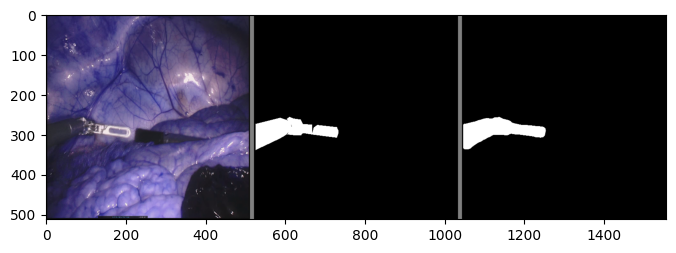

In [19]:
#Original image, the ground trouth, and the predicted outcome
plt.figure(figsize=(8,8))
plt.imshow(cv2.imread('/content/results/1frame280.png'))


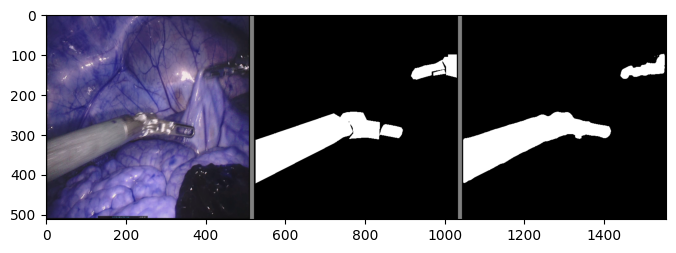

In [20]:
#Original image, the ground trouth, and the predicted outcome
plt.figure(figsize=(8,8))
plt.imshow(cv2.imread('/content/results/1frame293.png'))

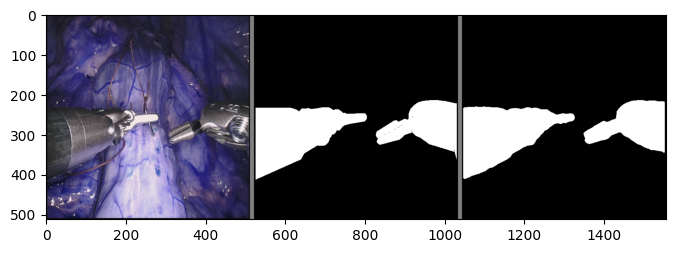

In [21]:
#Original image, the ground trouth, and the predicted outcome
plt.figure(figsize=(8,8))
plt.imshow(cv2.imread('/content/results/3frame257.png'))

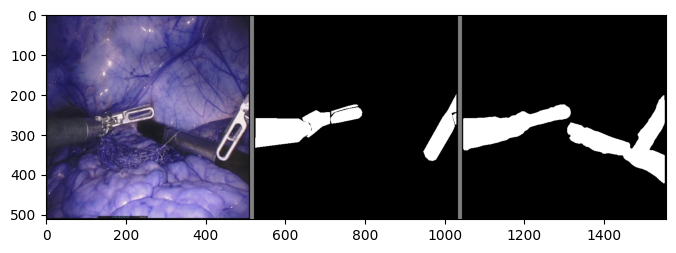

In [22]:
#Original image, the ground trouth, and the predicted outcome
plt.figure(figsize=(8,8))
plt.imshow(cv2.imread('/content/results/1frame225.png'))